<a href="https://colab.research.google.com/github/youngseo21/esaa_22/blob/main/assignment_221031.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import package
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

In [ ]:
# 데이터 전처리 함수
from sklearn.preprocessing import LabelEncoder

# Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(),inplace=True)
    df['Cabin'].fillna('N',inplace=True)
    df['Embarked'].fillna('N',inplace=True)
    df['Fare'].fillna(0,inplace=True)
    return df

# 머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
    df.drop(['PassengerId','Name','Ticket'],axis=1,inplace=True)
    return df

# 레이블 인코딩 수행. 
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin','Sex','Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

# 앞에서 설정한 Data Preprocessing 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

# **CHAPTER 03 평가**
___
- 머신러닝의 과정 : 데이터 가공/변환 - 모델 학습/예측 - 평가(Evaluation)
- 성능 평가 지표(Evaluation Metric)은 일반적으로 모델이 **분류**인지, **회귀**인지에 따라 여러 종류로 나뉜다.
  1. 회귀 : 실제값과 예측값의 오차 평균값(MSE)
  2. 분류 : 실제 결과 데이터와 예측 결과 데이터가 얼마나 정확하고 오류가 적게 발생하는가를 기반으로 평가
- 분류의 성능 평가 지표
  1. 정확도(Accuracy)
  2. 오차행렬(Confusion Matrix)
  3. 정밀도(Precision)
  4. 재현율(Recall)
  5. F1 스코어
  6. ROC AUC
- 분류는 결정 클래스 값의 종류에 따라 긍정/부정과 같은 2개의 결과값만을 가지는 **이진 분류**와 여러 개의 결정 클래스 값을 가지는 **멀티 분류**로 나뉜다.

## **01 정확도**
____

$$정확도 = \frac {예측 결과가 동일한 데이터 건수}{전체 예측 데이터 건수}$$
- 정확도 : 실제 데이터와 예측 데이터가 얼마나 같은지를 판단하는 지표이며 직관적으로 모델 예측 성능을 나타내는 평가 지표이다.
- 이진 분류의 경우, 데이터의 구성에 따라 ML 모델의 성능이 왜곡될 수 있어 정확도 하나만 가지고 성능을 평가하지는 않는다.

In [ ]:
from sklearn.base import BaseEstimator

# BaseEstimator 클래스를 상속받아, 아무런 학습을 하지 않고, 성별에 따라 생존자를 예측하는 Classifier
# BaseEstimator 클래스 : Customized 형태의 Estimator를 생성할 수 있다
class MyDummyClassifier(BaseEstimator):
    # fit() 메소드는 아무것도 학습하지 않음
    def fit(self, X , y=None):
        pass
    
    # predict(  메소드는 단순히 Sex feature가 1이면 0 , 그렇지 않으면 1로 예측
    def predict(self, X):
        pred = np.zeros( ( X.shape[0], 1 ))
        for i in range (X.shape[0]) :
            if X['Sex'].iloc[i] == 1:
                pred[i] = 0
            else :
                pred[i] = 1
        
        return pred

In [ ]:
# 예제에 필요한 타이타닉 데이터 로드 및 전처리
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

titanic_df = pd.read_csv('/content/drive/MyDrive/2022-1 ESAA/DataSet/titanic_train.csv')

# Feature, Target 데이터셋 분리
y_titanic_df = titanic_df['Survived']
X_titanic_df= titanic_df.drop('Survived', axis=1)

# Feature 데이터셋 전처리
X_titanic_df = transform_features(X_titanic_df)

# Train/Test
X_train, X_test, y_train, y_test=train_test_split(X_titanic_df, y_titanic_df, test_size = 0.2, random_state = 0)

In [ ]:
# 위에서 생성한 Dummy Classifier를 이용하여 학습/예측/평가 수행. 
myclf = MyDummyClassifier()
myclf.fit(X_train ,y_train)

mypredictions = myclf.predict(X_test)
print('Dummy Classifier의 정확도는: {0:.4f}'.format(accuracy_score(y_test , mypredictions)))

Dummy Classifier의 정확도는: 0.7877


- 위의 예제를 보면, 단순한 분류 알고리즘으로 예측을 했으나, 데이터의 구성에 의해 정확도 결과가 약 78.77%로 꽤 높게 나왔다. 따라서 정확도를 평가 지표로 사용할 때는 매우 신중해야 한다.
- Label 값이 불균형하게(imbalanced) 분포할 때, 정확도는 적합한 평가 지표가 아니다. MNIST 데이터셋을 가공하여 불균형한 데이터셋에 대해 정확도를 평가 지표로 사용할 때 어떤 문제가 발생할 수 있는지 살펴보자.

In [ ]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score

class MyFakeClassifier(BaseEstimator):
    def fit(self,X,y):
        pass
    
    # 입력값으로 들어오는 X 데이터셋의 크기만큼 모두 0값으로 만들어서 반환
    # 즉, 예측값이 모두 0으로 반환
    def predict(self,X):
        return np.zeros((len(X),1) , dtype = bool)

# 사이킷런의 내장 데이터 셋인 load_digits( )를 이용하여 MNIST 데이터 로딩
digits = load_digits()

# digits 번호(Label 값)가 7이면 True. 7이 아니면 False
# True와 False를 정수형으로 변환
y = (digits.target == 7).astype(int) 

# Train/Test
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state = 11)

In [ ]:
# 불균형한 레이블 데이터 분포도 확인
# 0이 1에 비해 매우 많다
print('레이블 테스트 세트 크기 :', y_test.shape)
print('테스트 세트 레이블 0 과 1의 분포도')
print(pd.Series(y_test).value_counts())

레이블 테스트 세트 크기 : (450,)
테스트 세트 레이블 0 과 1의 분포도
0    405
1     45
dtype: int64


In [ ]:
# Dummy Classifier로 학습/예측/정확도 평가
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train , y_train)
fakepred = fakeclf.predict(X_test)
print('모든 예측을 0으로 하여도 정확도는 : {:.3f}'.format(accuracy_score(y_test ,fakepred)))

모든 예측을 0으로 하여도 정확도는 : 0.900


- 이처럼 불균형한 레이블 데이터셋에서는 정확도로 모델의 성능을 평가할 수 없다.
- 이를 보완하기 위해, 여러 가지 분류 지표와 함께 적용해야 하는데, 이 중 오차 행렬(Confusion Matrix)이 있다.

## **02 오차 행렬**
____
- 오차행렬(Confusion matrix, 혼동행렬) : 학습된 분류 모델이 예측을 수행하면서 얼마나 헷갈리고(confused) 있는지도 함께 보여주는 지표. 즉, 예측 오류 값과 어떤 유형의 예측 오류가 발생하고 있는지를 함께 보여주는 지표. `confusion_matrix()` 메소드를 이용해 계산할 수 있다.

- 오차행렬은 4분면 행렬에서 실제 Label 클래스 값과 예측 Label 클래스 값이 어떠한 유형을 가지고 mapping되는지를 표현한다. 
| |Negative(0)|Positive(1)|
|------|---|---|
|Negative(0)|True Negative|False Positive|
|Positive(1)|False Negative|True Positive|

- mapping 유형
  1. True Negative : 예측값을 Negative(0)으로 예측했고, 실제 값 역시 Negative(0)
  2. False Positive : 예측값을 Positive(1)으로 예측했지만, 실제 값은 Negative(0)
  3. False Negative : 예측값을 Negative(0)으로 예측했지만, 실제 값은 Positive(1)
  4. True Positive : 예측값을 Positive(1)으로 예측했고, 실제 값 역시 Positive(1)


In [ ]:
from sklearn.metrics import confusion_matrix

# 앞 예제의 예측 결과인 fakepred와 실제 결과인 y_test의 Confusion Matrix
confusion_matrix(y_test, fakepred)

array([[405,   0],
       [ 45,   0]])

- 오차 행렬

| |Negative(0)|Positive(1)|
|------|---|---|
|Negative(0)|405|0|
|Positive(1)|45|0|

- 오차행렬 결과를 이용해 정확도를 계산할 수 있다.

$$정확도 = \frac {예측 결과가 동일한 데이터 건수}{전체 예측 데이터 건수}  = \frac {(TN + TP)}{(TN + FP + FN + TP}$$ 

- 보통 많은 데이터들은 중점적으로 찾아야 하는 매우 적은 수의 결과값에 Positive를 설정한다. 그런데 불균형한 이진 분류 데이터셋에서는 Positive 데이터 건수가 매우 작아, 이러한 데이터에 기반한 ML 알고리즘은 주로 Positive보다는 Negative로 예측하려는 경향이 더 강해진다. 결과적으로 TN은 매우 커지고, TP는 매우 작아지고, FN이 매우 작으며, FP 역시 매우 작아진다.



## **03 정밀도와 재현율**
____
- 정확도는 분류 모델의 성능을 측정할 수 있는 요소들 중 한 가지일 뿐, 불균형한 데이터셋에서는 성능 지표로서 신뢰가 떨어지는데, 이때 정밀도와 재현율이 평가 지표로 더 선호된다.
- 정밀도와 재현율은 Positive 데이터셋의 예측 성능에 좀 더 초점을 맞춘 지표이다.
1. **정밀도**
  - 예측을 Positive로 한 대상 중에 예측값과 실제값이 Positive로 일치한 데이터의 비율로 양성 예측도라고도 한다.
  - 재현율은 실제 Positive인 데이터를 Negative로 잘못 예측하면 손실이 큰 경우 중요하다.(예 : 암 판단 모델이나 금융 사기 적발 모델)
  - 사이킷런의 `precision_score()` 메서드 사용

$$정밀도 = \frac {TP}{(FP + TP)}$$ 

2. **재현율**
  - 실제 값이 Positive인 대상 중 예측과 실제 값이 Positive로 일치한 데이터의 비율로 민감도(Sensitivity) 혹은 TPR(True Positive Rate)으로 불린다.
  - 정밀도는 실제 Negative인 데이터를 Positive로 잘못 예측하면 손실이 큰 경우 중요하다.(예 : 스팸 메일 여부 판단 모델)
  - 사이킷런의 `recall_score()` 메서드 사용

$$재현율 = \frac {TP}{(FN + TP)}$$ 

- 두 지표는 상호 보완적인 지표이며, 재현율과 정밀도 모두 높은 수치를 얻을 때 모델의 성능이 가장 좋다고 평가한다. 하지만 어느 한 평가 지표만 매우 높고 다른 지표는 매우 낮을 경우는 바람직하지 않다.



In [ ]:
# 앞에서 만든 MyFakeClassifier는 TP 값이 하나도 없기 때문에, 정밀도와 재현율 값이 모두 0
from sklearn.metrics import accuracy_score, precision_score , recall_score

print("정밀도:", precision_score(y_test, fakepred))
print("재현율:", recall_score(y_test, fakepred))

정밀도: 0.0
재현율: 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import accuracy_score, precision_score , recall_score , confusion_matrix

# confusion matrix, accuracy, precision, recall 등의 평가 지표를 한 번에 호출하는 함수
def get_clf_eval(y_test , pred):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'.format(accuracy , precision ,recall))

In [ ]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression

# 원본 데이터를 재로딩, 데이터 가공
titanic_df = pd.read_csv('/content/drive/MyDrive/2022-1 ESAA/DataSet/titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df= titanic_df.drop('Survived', axis = 1)
X_titanic_df = transform_features(X_titanic_df)

# Train/Test
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.20, random_state=11)

# 타이타닉 생존자를 로지스틱 회귀 모델을 기반으로 예측
lr_clf = LogisticRegression()

lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)

# Model Test
get_clf_eval(y_test, pred)

오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


- 위의 예제에서 정밀도에 비해 재현율이 낮게 나왔다.
- 재현율 혹은 정밀도를 좀 더 강화할 방법은 무엇일까?

### | **정밀도/재현율 트레이드오프**
___
- 분류 업무에서 정밀도 또는 재현율이 특별히 강조되어야 할 경우, 분류의 결정 임계값(Threshold)을 조정해 정밀도 또는 재현율 수치를 높일 수 있다.
- **정밀도/재현율의 트레이드오프(Trade-off)** : 정밀도와 재현율이 상호 보완적인 지표이기 때문에, 어느 한쪽을 강제로 높이면 다른 하나의 수치가 떨어지기 쉽다.
- 사이킷런의 분류 알고리즘은 예측 데이터가 특정 Label(결정 클래스 값)에 속하는지 계산하기 위해 먼저 개별 Label 별로 결정 확률을 계산한 후, 예측 확률이 큰 Label 값으로 예측한다. 이때 일반적으로 이진 분류에서는 임계값을 0.5(50%)로 정하고 이 값보다 확률이 크면 Positive, 작으면 Negative로 결정한다.
- 사이킷런은 개별 데이터 별로 예측 확률을 반환하는 `predict_proba()`를 제공한다.
  1. 입력 파라미터 : `predict()` 메서드와 동일하게 테스트 피처 데이터셋 입력
  2. 반환 값 : 개별 클래스의 예측 확률 결과 ndarray **(입력 데이터셋의 표본 개수) x (예측 클래스 값 유형)** 형태로 반환. 첫번째 Column은 클래스 값 0에 대한 예측 확률, 두 번째 Column은 클래스 값 1에 대한 예측 확률이다.( cf. `predict()` 메서드는 예측 결과 클래스 값을 반환한다.) 

In [ ]:
pred_proba = lr_clf.predict_proba(X_test)
pred  = lr_clf.predict(X_test)
print('pred_proba()결과 Shape : {0}'.format(pred_proba.shape))
print('pred_proba array에서 앞 3개만 샘플로 추출 \n: ', pred_proba[:3])

# 예측 확률 array와 예측 결과값 array를 병합(concatenate)하여 예측 확률과 결과값을 한눈에 확인
pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1,1)],axis=1)
print('두개의 class 중에서 더 큰 확률을 클래스 값으로 예측 \n',pred_proba_result[:3])

pred_proba()결과 Shape : (179, 2)
pred_proba array에서 앞 3개만 샘플로 추출 
:  [[0.46191519 0.53808481]
 [0.878675   0.121325  ]
 [0.87716185 0.12283815]]
두개의 class 중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.46191519 0.53808481 1.        ]
 [0.878675   0.121325   0.        ]
 [0.87716185 0.12283815 0.        ]]


- `predict()` 메서드는 `predict_proba()` 메서드에 기반해 생성된 API. `predict_proba()`를 호출한 뒤 반환된 배열에서 분류 결정 임계값보다 큰 값이 들어있는 칼럼의 위치를 받아서 최종적으로 예측 클래스를 결정한다.
- 이러한 원리를 직접 구현하면서 정밀도/재현율 트레이드오프 방식을 이해해보도록 하자.

#### **[Binarizer 클래스]**
- 위에서 알아본 `predict()`의 알고리즘을 구현하기 위해, 사이킷런의 Binarizer 클래스를 이용할 것이다.


In [ ]:
from sklearn.preprocessing import Binarizer

X = [[ 1, -1,  2],
     [ 2,  0,  0],
     [ 0,  1.1, 1.2]]

# threshold 기준값보다 같거나 작으면 0을, 크면 1을 반환
binarizer = Binarizer(threshold = 1.1)                     
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


#### **[Binarizer 클래스를 이용해 predict() 메서드의 pseudo 코드]**
- 이제 Binarizer 클래스를 이용해 `predict()` 메서드의 pseudo 코드를 만들어 보자.
- `LogisticRegression` 객체의 `predict_proba()` 메서드로 구한 각 클래스별 예측 확률 값(pred_proba 변수)을 받은 후, 분류 결정 임계값(threshold)을 0.5로 지정한 Binarizer 클래스를 적용해 최종 예측 값을 구할 것이다.
- 이 최종 예측값에 대해 앞서 만든 `get_clf_eval()` 함수를 적용해 평가 지표도 출력해보도록 한다. 출력하면 앞 예제에서 `predict()`으로 예측한 결과에 대한 성능 평가 지표 값과 동일한 것을 알 수 있다.

In [ ]:
from sklearn.preprocessing import Binarizer

#Binarizer의 threshold 설정값(분류 결정 임곗값a0
custom_threshold = 0.5

# predict_proba() 반환값의 두번째 컬럼, 즉 Positive 클래스 컬럼 추출
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

# Binarizer를 적용
binarizer = Binarizer(threshold= custom_threshold).fit(pred_proba_1) 
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869


In [ ]:
# Binarizer의 threshold 설정값을 0.4로 설정(임계값 0.5 -> 0.4) 
custom_threshold = 0.4

# predict_proba() 반환값의 두번째 컬럼, 즉 Positive 클래스 컬럼 추출
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

# Binarizer를 적용
binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1) 
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test , custom_predict)

오차 행렬
[[98 20]
 [10 51]]
정확도: 0.8324, 정밀도: 0.7183, 재현율: 0.8361


#### **[임계값에 따른 재현율/정밀도 변화]**
- 임계값을 낮췄더니 재현율 값이 올라가고, 정밀도가 떨어졌다.
  + 분류 결정 임계값은 Positive 예측값을 결정하는 확률의 기준
  + 임계값을 낮추면 True 값이 많아져 재현율 값이 높아진다.
- 임계값을 0.4에서 0.6까지 0.05씩 증가시키며 평가 지표를 살펴보도록 하자.

In [ ]:
# 테스트를 수행할 모든 임계값을 리스트 객체로 저장 
thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]

def get_eval_by_threshold(y_test , pred_proba_c1, thresholds):
    # thresholds list 객체 내의 값을 차례로 반복하면서 Evaluation 수행
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1) 
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값:',custom_threshold)
        get_clf_eval(y_test , custom_predict)

get_eval_by_threshold(y_test ,pred_proba[:,1].reshape(-1,1), thresholds )

임곗값: 0.4
오차 행렬
[[98 20]
 [10 51]]
정확도: 0.8324, 정밀도: 0.7183, 재현율: 0.8361
임곗값: 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.7656, 재현율: 0.8033
임곗값: 0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869
임곗값: 0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8364, 재현율: 0.7541
임곗값: 0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8824, 재현율: 0.7377


|평가지표|0.4|0.45|0.5|0.55|0.6|
|------|----|----|----|----|----|
|정확도|0.8324|0.8492|0.8492|0.8659|0.8771|
|정밀도|0.7183|0.7656|0.7742|0.8364|0.8824|
|재현율|0.8361|0.8033|0.7869|0.7541|0.7377|

- `precision_recall_curve()` API : 사이킷런의 임계값 변화에 따른 평가 지표 값을 반환하는 메서드
  1. 입력 파라미터 : `y_true`(실제 클래스값 배열), `probas_pred`(Positive Column의 예측 확률 배열)
  2. 반환 값 : 임계값 별로 정밀도/재현율 값을 배열로 반환한다.

In [ ]:
from sklearn.metrics import precision_recall_curve

# Label 값이 1일때의 예측 확률을 추출 
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1] 

# precision_recall_curve() 메서드에 실제값 데이터 셋과 레이블 값이 1일 때의 예측 확률 입력 
# 정밀도/재현율/임계값을 각각의 변수에 반환
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)

print('반환된 분류 결정 임계값 배열의 Shape:', thresholds.shape)
print('반환된 precisions 배열의 Shape:', precisions.shape)
print('반환된 recalls 배열의 Shape:', recalls.shape)

# Sample이 5건일 때의 임계값과 그에 따른 정밀도와 재현율 값
print("thresholds 5 sample:", thresholds[:5])
print("precisions 5 sample:", precisions[:5])
print("recalls 5 sample:", recalls[:5])
print()

# 일반적으로 0.11~0.95의 임계값을 사용 : 너무 작은 값 단위로 많이 구성되어 있음
# 반환된 임계값 배열 Row가 147건이므로 샘플로 10건만 추출하되, 임계값을 15단계로 추출
thr_index = np.arange(0, thresholds.shape[0], 15)
print('샘플 추출을 위한 임계값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임계값: ', np.round(thresholds[thr_index], 2))

# 15 단계로 추출된 임계값에 따른 정밀도와 재현율 값 
print('샘플 임계값 별 정밀도: ', np.round(precisions[thr_index], 3))
print('샘플 임계값 별 재현율: ', np.round(recalls[thr_index], 3))

반환된 분류 결정 임계값 배열의 Shape: (143,)
반환된 precisions 배열의 Shape: (144,)
반환된 recalls 배열의 Shape: (144,)
thresholds 5 sample: [0.10390978 0.10391203 0.1039372  0.10786305 0.10888586]
precisions 5 sample: [0.38853503 0.38461538 0.38709677 0.38961039 0.38562092]
recalls 5 sample: [1.         0.98360656 0.98360656 0.98360656 0.96721311]

샘플 추출을 위한 임계값 배열의 index 10개: [  0  15  30  45  60  75  90 105 120 135]
샘플용 10개의 임계값:  [0.1  0.12 0.14 0.19 0.28 0.4  0.56 0.67 0.82 0.95]
샘플 임계값 별 정밀도:  [0.389 0.44  0.466 0.539 0.647 0.729 0.836 0.949 0.958 1.   ]
샘플 임계값 별 재현율:  [1.    0.967 0.902 0.902 0.902 0.836 0.754 0.607 0.377 0.148]


- 임계값이 증가할수록 정밀도 값은 높아지나 재현율 값은 낮아진다.
- 이러한 변화를 그래프로 시각화해보자.

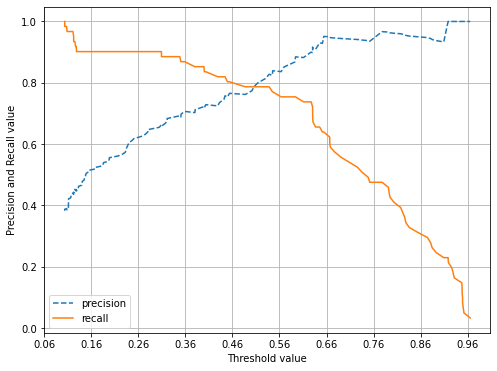

In [ ]:
def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold 값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    # 정밀도는 점선, 재현율은 실선으로 표시
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
    
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1] )

### | **정밀도와 재현율의 맹점**
___
- Positive 예측의 임계값을 변경함에 따라 정밀도와 재현율 값이 변화한다.
- 임계값을 변경할 때는 업무 환경에 따라 정밀도와 재현율을 상호 보완할 수 있는 수준으로 변경해야 한다.
- 단순히 하나의 성능 지표 수치를 높이기 위해 임계값을 변경하는 것은 의미 없다.
- 정밀도 혹은 재현율 중 하나에 상대적인 중요도를 부여할 수는 있지만, 하나만 강조하면 안 된다.

#### **[정밀도가 100% 되는 방법]**
- 확실히 기준에 맞는 경우에는 무조건 Positive로 예측하고 나머지는 모두 Negative로 예측한다.
- 예를 들면 환자가 80세 이상, 비만, 이전에 암 진단을 받은 적 있음, 암 세포의 크기가 상위 0.1% 이상이면 무조건 Positive이고 아닐 경우 Negative로 예측하면 된다. 그렇게 하면, 전체 환자 1000명 중 기준에 맞는 환자가 단 1명 뿐이더라도 정밀도는 100%(1/(1+0))가 된다.

#### **[재현율이 100% 되는 방법]**
- 모든 환자를 Positive로 예측한다.
- 위의 예시에 적용하면, 전체 환자 1000명을 다 Positive로 예측하는 것이다. 그렇게 하면 실제 양성인 사람이 30명 정도라도 재현율이 30/(30+0)으로 100%가 된다.

## **04 F1 스코어**
____
- F1 스코어(score) : 정밀도와 재현율을 결합한 지표
- 정밀도와 재현율이 어느 한 쪽으로 치우치지 않을 때 높은 값을 가진다.

$$F1 = \frac {2}{\frac {1}{recall} + \frac {1}{precision}} = 2* \frac {precision * recall}{precision + recall}$$ 

- 사이킷런의 `f1_score()` API 사용

In [ ]:
from sklearn.metrics import f1_score 
f1 = f1_score(y_test , pred)
print('F1 스코어: {0:.4f}'.format(f1))

F1 스코어: 0.7805


In [ ]:
# 앞에서 만들었던 get_clf_eval() 함수 수정
def get_clf_eval(y_test , pred):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    # F1 스코어 추가
    f1 = f1_score(y_test,pred)
    print('오차 행렬')
    print(confusion)
    # f1 score print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f} \n'.format(accuracy, precision, recall, f1))

thresholds = [0.4 , 0.45 , 0.50 , 0.55 , 0.60]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

임곗값: 0.4
오차 행렬
[[98 20]
 [10 51]]
정확도: 0.8324, 정밀도: 0.7183, 재현율: 0.8361, F1:0.7727 

임곗값: 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.7656, 재현율: 0.8033, F1:0.7840 

임곗값: 0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869, F1:0.7805 

임곗값: 0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8364, 재현율: 0.7541, F1:0.7931 

임곗값: 0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8824, 재현율: 0.7377, F1:0.8036 



|평가지표|0.4|0.45|0.5|0.55|0.6|
|------|----|----|----|----|----|
|정확도|0.8324|0.8492|0.8492|0.8659|0.8771|
|정밀도|0.7183|0.7656|0.7742|0.8364|0.8824|
|재현율|0.8361|0.8033|0.7869|0.7541|0.7377|
|F1|0.7727|0.7840|0.7805|0.7931|0.8036|

- 임계값이 0.6일 때, F1 스코어의 값이 가장 좋지만, 재현율은 크게 감소한다.

## **05 ROC 곡선과 AUC**
____
- ROC 곡선과 이에 기반한 AUC 스코어는 이진 분류 모델의 예측 성능을 측정할 때 중요하게 사용되는 지표이다.
- ROC 곡선(Receiver Operation Characteris Curve) : 2차 대전 때 통신 장비 성능 평가를 위해 고안된 것으로, FPR(False Positive Rate)이 변할 때, TPR(True Positive Rate)이 어떻게 변하는지를 나타내는 곡선.
  + FPR을 X축으로, TPR을 Y축으로 한다.
  + TPR은 재현율(민감도)을 의미하며, 실제로 Positive인 값이 정확히 예측되어야 하는 수준을 의미한다. 
  $$TPR = \frac {TP}{(FN + TP)}$$ 
  + TNR은 특이성으로, 실제로 Negative인 값이 정확히 예측되어야 하는 수준을 의미한다.
  $$TNR = \frac {TN}{(FP + TN)}$$ 
  + FPR은 $1-TNR$ 에 해당한다.
- ROC 곡선이 가운데 직선에 가까울수록 성능이 떨어지며, 멀어질수록 성능이 뛰어나다.
- ROC 곡선은 FPR을 0부터 1까지 변경하면서 TPR의 변화를 확인한다.
  + 임계값을 1로 지정하면 FP = 0이 되어, FPR가 0이 된다.
  + 임계값을 0으로 지정하면 TN = 0이 되어, FPR이 1이 된다.
- ROC 곡선은 사이킷런의 `roc_curve()` API를 이용해 그릴 수 있다.
  1. 입력 파라미터 : y_true(실제 클래스 값 array), y_score(Positive Column의 예측 확률이 보통 사용된다.)
  2. 반환 값 : fpr(FPR 값을 array로 반환), tpr(TPR 값을 array로 반환), thresholds(threshold 값 array)

In [ ]:
# 타이타닉 생존자 예측 모델의 FPR, TPR, 임계값 구하기
# LogisticRegression 모델
from sklearn.metrics import roc_curve

# Label 값이 1일때의 예측 확률을 추출(y_score)
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1] 

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)

# 반환된 임계값 배열에서 샘플로 데이터를 추출하되, 임곗값을 5 단계로 추출. 
# thresholds[0]은 max(예측확률)+1로 임의 설정됨. 이를 제외하기 위해 np.arange는 1부터 시작
thr_index = np.arange(1, thresholds.shape[0], 5)
print('샘플 추출을 위한 임곗값 배열의 index:', thr_index)
print('샘플 index로 추출한 임곗값: ', np.round(thresholds[thr_index], 2))

# 5 단계로 추출된 임계값에 따른 FPR, TPR 값
print('샘플 임곗값별 FPR: ', np.round(fprs[thr_index], 3))
print('샘플 임곗값별 TPR: ', np.round(tprs[thr_index], 3))

샘플 추출을 위한 임곗값 배열의 index: [ 1  6 11 16 21 26 31 36 41 46 51]
샘플 index로 추출한 임곗값:  [0.97 0.65 0.63 0.56 0.45 0.4  0.35 0.15 0.13 0.11 0.11]
샘플 임곗값별 FPR:  [0.    0.017 0.034 0.076 0.127 0.169 0.203 0.466 0.585 0.686 0.797]
샘플 임곗값별 TPR:  [0.033 0.639 0.721 0.754 0.803 0.836 0.885 0.902 0.934 0.967 0.984]


- 임계값이 1 근처에서 점점 작아지고, 이에 따라 FPR이 점점 커지고, TPR은 더 많이 커진다.
- 이러한 변화를 시각해보자.

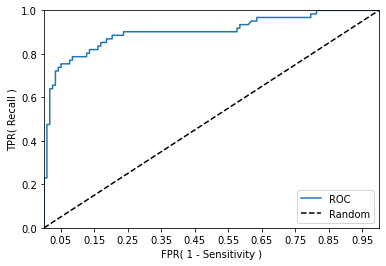

In [ ]:
def roc_curve_plot(y_test , pred_proba_c1):
    # 임계값에 따른 FPR, TPR 값을 반환 받음. 
    fprs , tprs , thresholds = roc_curve(y_test ,pred_proba_c1)

    # ROC Curve를 plot 곡선으로 그림. 
    plt.plot(fprs , tprs, label='ROC')
    # 가운데 대각선 직선을 그림. 
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    
    # FPR X 축의 Scale을 0.1 단위로 변경  
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel('FPR( 1 - Sensitivity )'); plt.ylabel('TPR( Recall )')
    plt.legend()
    plt.show()
    
roc_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1] )

- 일반적으로 ROC 곡선 자체는 FPR과 TPR의 변화를 확인할 때 이용하며, 분류 모델의 성능 평가 지표로는 ROC 곡선 면적에 기반한 AUC 값으로 결정한다.
- **AUC(Area Under Cureve)** : ROC 곡선 밑의 면적을 구한 것으로 일반적으로 1에 가까울수록 모델의 성능이 좋다.
- ROC 곡선이 가파를수록 면적이 1에 가까워진다.
- 앞에서 만든 `get_clf_eval` 함수에 ROC AUC 값을 측정하는 코드를 추가해보자.

In [ ]:
def get_clf_eval(y_test, pred = None, pred_proba = None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
          F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))